## Analísis Topologico de Datos para la segmentacion de imagenes tumorales

In [2]:
import openslide
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from ripser import ripser, Rips

In [3]:
def abrir_svs(svs_file_path):
    try:
        slide = openslide.OpenSlide(svs_file_path)
    except Exception as e:
        print(f"Error al abrir el archivo {svs_file_path}: {e}")
        return None
    return slide

In [4]:
def mostrar_niveles(slide):
    level_count = slide.level_count
    print(f'Niveles de resolución disponibles: {level_count}')
    for level in range(level_count):
        print(f'Nivel {level}: {slide.level_dimensions[level]}')
    return level_count

In [5]:
def convertir_y_binarizar(regiones, umbral):
    regiones_grises = [region.convert('L') for region in regiones]
    regiones_binarizadas = [np.where(np.array(region_gris) < umbral, 0, 1) for region_gris in regiones_grises]
    return np.array(regiones_binarizadas)

In [6]:
def region_wsi(level, x, y, region_width, region_height, slide):
    width, height = slide.dimensions
    # Verifica que las coordenadas y el tamaño de la región sean válidos
    if x + region_width > width or y + region_height > height:
        raise ValueError("La región especificada está fuera de los límites de la imagen.")
    # Extrae la región
    region = slide.read_region((x, y), level, (region_width, region_height))
    # Convierte la región a un formato que se pueda mostrar con PIL
    region = region.convert("L")
    return region

In [7]:
def procesar_imagenes(svs_file_paths, coordenadas, niveles, tamanio):
    regiones_wsi = []
    for svs_file_path, (coords, tam, levels) in zip(svs_file_paths, zip(coordenadas, tamanio, niveles)):
        slide = abrir_svs(svs_file_path)
        if slide is None:
            continue
        
        mostrar_niveles(slide)

        for (x_init, y_init), (region_width, region_height), level in zip(coords, tam, levels):
            region = region_wsi(level, x_init, y_init, region_width, region_height, slide)
            if x_init != 0 and y_init != 0:
                regiones_wsi.append(region)
            # plt.imshow(region)
            # plt.axis('off')
            # plt.show()
        slide.close()
    return regiones_wsi

In [8]:
def convertir_y_binarizar(regiones, umbral):
    regiones_binarizadas = []
    
    for region in regiones:
        region_gris = np.array(region)
        m, n = region_gris.shape
        for t in range(umbral):
            region_binarizada = np.zeros((m, n), dtype=int)
            for i in range(m):
                for j in range(n):
                    if region_gris[i, j] < t:
                        region_binarizada[i, j] = 0
                        # Incluir las esquinas y lados
                        if i > 0: region_binarizada[i-1, j] = 0
                        if i < m-1: region_binarizada[i+1, j] = 0
                        if j > 0: region_binarizada[i, j-1] = 0
                        if j < n-1: region_binarizada[i, j+1] = 0
                        if i > 0 and j > 0: region_binarizada[i-1, j-1] = 0
                        if i > 0 and j < n-1: region_binarizada[i-1, j+1] = 0
                        if i < m-1 and j > 0: region_binarizada[i+1, j-1] = 0
                        if i < m-1 and j < n-1: region_binarizada[i+1, j+1] = 0
                    else:
                        region_binarizada[i, j] = 1
            # Agregar a la lista de regiones binarizadas
            regiones_binarizadas.append(region_binarizada)
    return regiones_binarizadas

In [9]:
def betti_numeros(bin_matriz):
    # Invert the matrix to find the white components
    inverted_matriz = 1 - bin_matriz

    # Definir una estructura de conectividad personalizada
    structure = np.array([[1, 1, 1],
                    [1, 1, 1],
                    [1, 1, 1]])

    # Obtenemos las regiones encontradas en la matriz binaria
    ciclos_matriz, num_hoyos = label(inverted_matriz, structure=structure)
    beta1 = num_hoyos
    return beta1, ciclos_matriz

In [10]:
def mostrar_en_grid(imagenes, filas, columnas, tamano_figura=(10, 10)):
    fig, axs = plt.subplots(filas, columnas, figsize=tamano_figura)
    axs = axs.ravel()
    
    for i, imagen in enumerate(imagenes):
        axs[i].imshow(imagen)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

## Obtenemos los parches de una imagen WSI

In [11]:
# ['../svs-cancer/MSB-00263-04-05.svs', '../svs-cancer/MSB-00263-04-06.svs']
# [[(0, 0), (6079, 7887), (12000, 7500), (7500, 8000), (4000, 4000), (8000, 13000), (14500, 8600)]]
# [[(1618, 1668), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128)]]
# [[2, 1, 1, 1, 1, 1, 1]]

svs_file_paths = ['./svs-images/MSB-00263-04-05.svs']

coordenadas = [[(0, 0), (5800, 17100), (17000, 11800)]]

tam = [[(1618, 1668), (400, 400), (400, 400)]]

niveles = [[2, 1, 1]]

# Procesar imágenes
regiones_wsi = procesar_imagenes(svs_file_paths, coordenadas, niveles, tam)

Niveles de resolución disponibles: 3
Nivel 0: (25895, 26695)
Nivel 1: (6473, 6673)
Nivel 2: (1618, 1668)


In [ ]:
mostrar_en_grid(regiones_wsi, 2, 3)

### Obtenemos el primer parche generado (parche 0)

In [12]:
umbral_t = 255
# Binarizar las imágenes
imagenes_binarizadas_cancer_0 = convertir_y_binarizar([regiones_wsi[0]], umbral_t)

# Obtenemos el numero de betti beta 1 para cada B(t)
betas1_0 = []
for t, img_bin in enumerate(imagenes_binarizadas_cancer_0):
    beta1, ciclos_matriz = betti_numeros(img_bin)
    betas1_0.append(beta1)

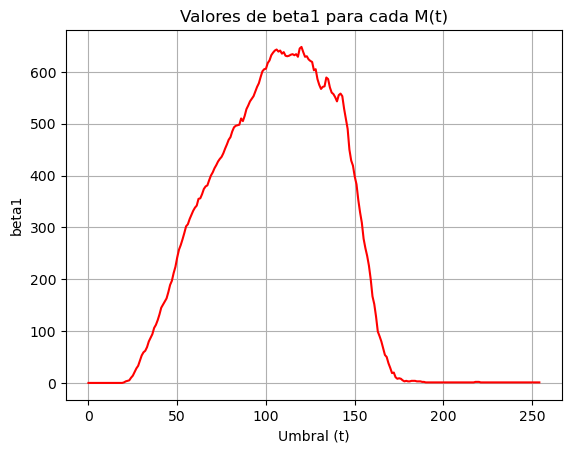

In [13]:
# Generar el eje x (por ejemplo, el índice de cada imagen binaria)
x_values_0 = range(len(imagenes_binarizadas_cancer_0))

# Graficar los valores de beta1 en función del índice de la imagen
plt.plot(x_values_0, betas1_0, linestyle='-', color='red')
# Etiquetas y título
plt.xlabel('Umbral (t)')
plt.ylabel('beta1')
plt.title('Valores de beta1 para cada M(t)')

# Mostrar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [ ]:
rips = Rips(maxdim=1)
diagrams = rips.fit_transform(np.array(imagenes_binarizadas_cancer_0[150]))

# Graficar el diagrama de persistencia
plt.figure(dpi=300, figsize=(3, 3))
rips.plot(diagrams, show=True)
plt.show()

In [ ]:
# Seleccionar las matrices específicas
indices = [0, 51, 70, 90, 110, 140, 160, 254]
matrices_seleccionadas = [imagenes_binarizadas_cancer_0[i] for i in indices]

# Definir el tamaño del grid (por ejemplo, 2 filas y 4 columnas)
filas, columnas = 2, 4

# Crear una figura y ejes
fig, axs = plt.subplots(filas, columnas, figsize=(12, 6))

# Agregar cada imagen al grid
for i, ax in enumerate(axs.flatten()):
    ax.imshow(matrices_seleccionadas[i] * 255, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    ax.set_title(f'Umbral t = {indices[i]}')
    
# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()

### Obtenemos el primer parche generado (parche 1)

In [16]:
umbral_t = 255
# Binarizar las imágenes
imagenes_binarizadas_cancer_1 = convertir_y_binarizar([regiones_wsi[1]], umbral_t)

# Obtenemos el numero de betti beta 1 para cada B(t)
betas1_1 = []
for t, img_bin in enumerate(imagenes_binarizadas_cancer_1):
    beta1, ciclos_matriz = betti_numeros(img_bin)
    betas1_1.append(beta1)

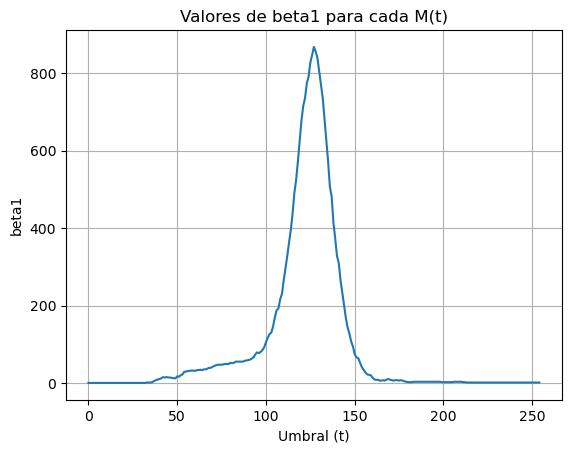

In [17]:
# Generar el eje x (por ejemplo, el índice de cada imagen binaria)
x_values_1 = range(len(imagenes_binarizadas_cancer_1))

# Graficar los valores de beta1 en función del índice de la imagen
plt.plot(x_values_1, betas1_1, linestyle='-')
# Etiquetas y título
plt.xlabel('Umbral (t)')
plt.ylabel('beta1')
plt.title('Valores de beta1 para cada M(t)')

# Mostrar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Comparamos las graficas de los betti 1 obtenidas por cada parche

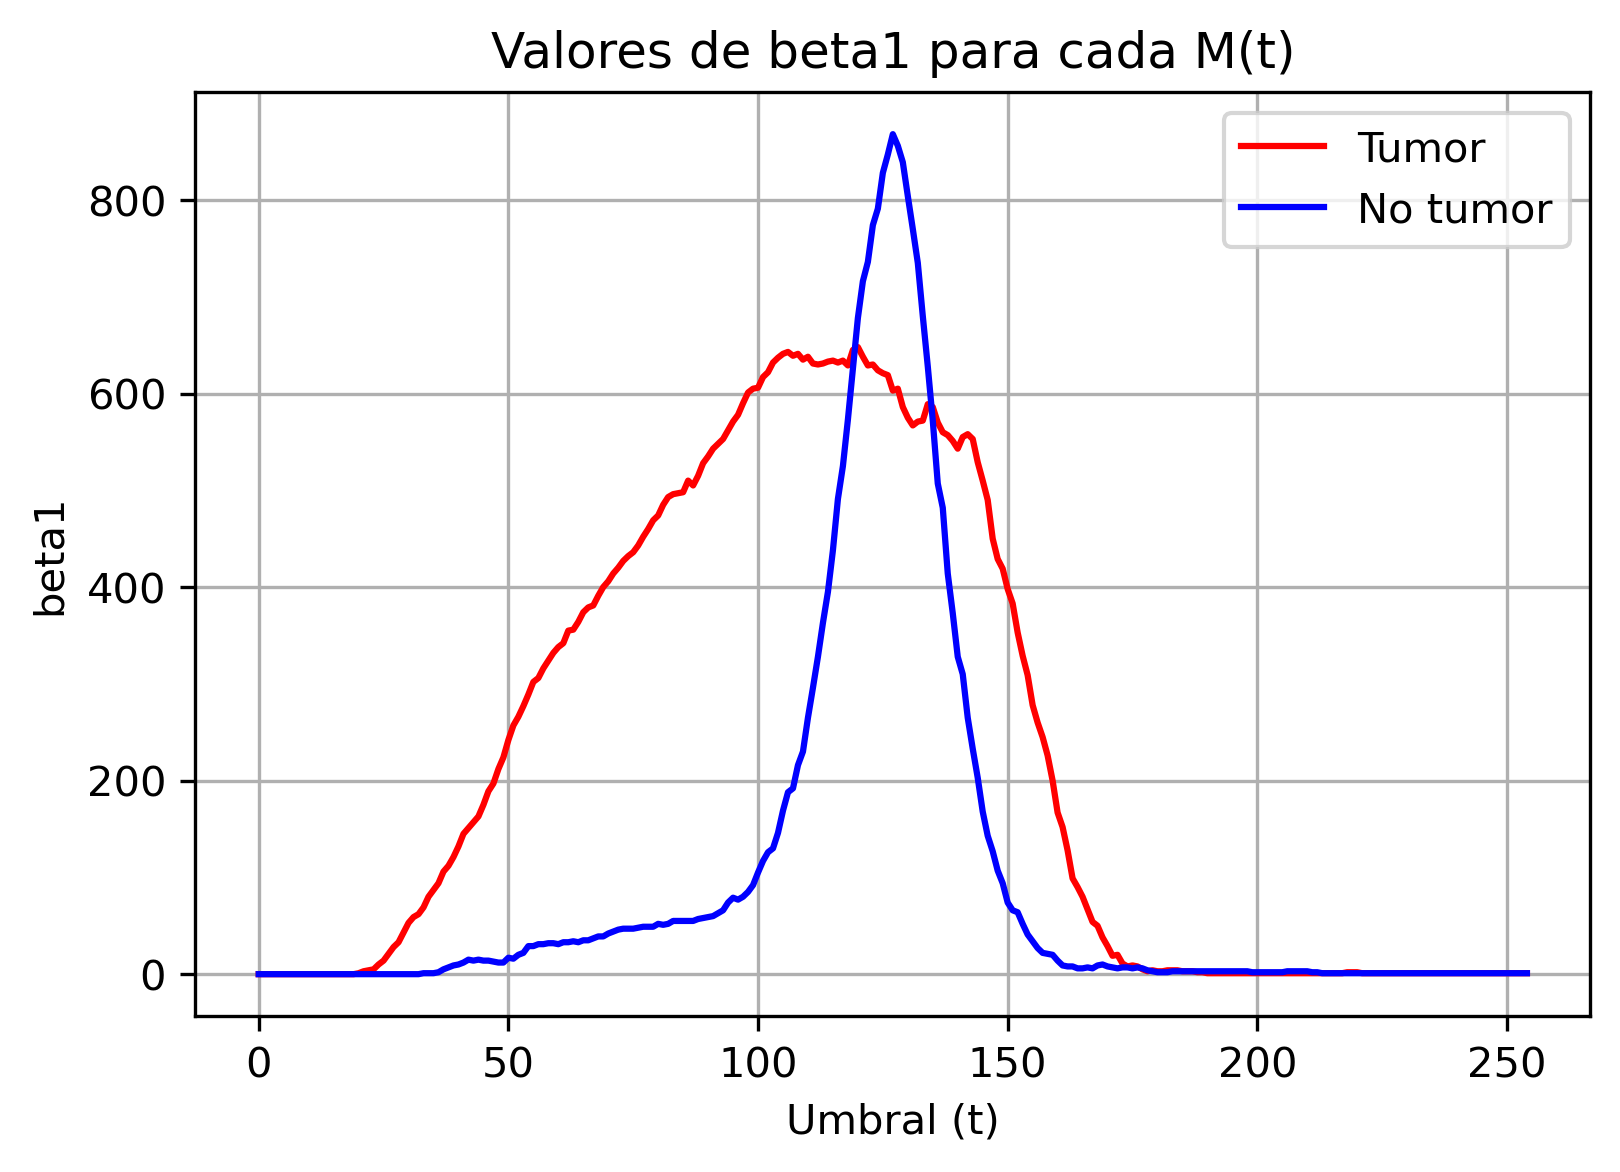

In [20]:
# Generar el eje x (por ejemplo, el índice de cada imagen binaria)
x_values_0 = range(len(imagenes_binarizadas_cancer_0))
x_values_1 = range(len(imagenes_binarizadas_cancer_1))

# Crear la figura y los ejes
plt.figure(dpi=300, figsize=(6, 4))

# Graficar los valores de beta1 para el primer conjunto de datos
plt.plot(x_values_0, betas1_0, color='red', linestyle='-', label='Tumor')

# Graficar los valores de beta1 para el segundo conjunto de datos
plt.plot(x_values_1, betas1_1, color='blue', linestyle='-', label='No tumor')

# Etiquetas y título
plt.xlabel('Umbral (t)')
plt.ylabel('beta1')
plt.title('Valores de beta1 para cada M(t)')

# Mostrar la cuadrícula
plt.grid(True)

# Agregar la leyenda
plt.legend()

In [ ]:
# from PIL import Image
# import os

In [ ]:
# # Crear una carpeta para guardar las imágenes si no existe
# output_folder = './imagenes_binarizadas'
# os.makedirs(output_folder, exist_ok=True)

In [ ]:
# indices = [0, 51, 70, 90, 110, 140, 160, 254]
# matrices_seleccionadas = [imagenes_binarizadas_cancer[i] for i in indices]
# # Convertir valores de 1 y 0 a 255 y 0 para imágenes binarias
# matrices_seleccionadas = [(matriz * 255).astype(np.uint8) for matriz in matrices_seleccionadas]

# # Crear una carpeta para guardar las imágenes si no existe
# output_folder = 'imagenes_binarizadas'
# os.makedirs(output_folder, exist_ok=True)

# # Guardar cada matriz como una imagen
# for i, matriz in enumerate(matrices_seleccionadas):
#     # Convertir la matriz a una imagen PIL
#     imagen = Image.fromarray(matriz, mode='L')  # 'L' indica modo de escala de grises
    
#     # Guardar la imagen en la carpeta especificada
#     imagen.save(os.path.join(output_folder, f'imagen_{i}.png'))
